In [1]:
import ast
import math
import random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Build Movie-Attribute Graph

In [2]:
temp_movies_df = pd.read_csv("generated_data/movies_small_with_clusters.csv")
temp_credits_df = pd.read_csv("generated_data/credits_small.csv")

In [3]:
temp_movies_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count', 'movieId',
       'overview_cluster'],
      dtype='object')

In [4]:
# create new dataframes with relevant features, after processing 
# features that are not useful in calculating the Adamic-Adar measure are not included
#     - features that contain unique values for each movie (e.g. title)
#     - features that are binary (e.g. adult)
#     - features that are highly correlated with other features (e.g. original_languages and spoken_languages)
#     - features that contain arbitrary numeric values (e.g. popularity)
movies_df = pd.DataFrame() 
movies_df["collection"] = temp_movies_df["belongs_to_collection"].fillna("{}")
movies_df["budget"] = np.log10(pd.to_numeric(temp_movies_df["budget"]).fillna(0).replace(0, 1)).round(0).astype(int) # order of magnitude of budget
movies_df["genres"] = temp_movies_df["genres"].fillna("[]")
movies_df["language"] = temp_movies_df["original_language"].fillna("")
movies_df["companies"] = temp_movies_df["production_companies"].fillna("[]")
movies_df["countries"] = temp_movies_df["production_countries"].fillna("[]")
movies_df["revenue"] = np.log10(temp_movies_df["revenue"].fillna(0).replace(0, 1)).round(0).astype(int) # order of magnitude of revenue
movies_df["overview_cluster"] = temp_movies_df["overview_cluster"]
movies_df["id"] = temp_movies_df["movieId"]
movies_df = movies_df.set_index("id")
movies_df = movies_df[~movies_df.index.duplicated(keep="first")] # drop rows with duplicate indices

credits_df = pd.DataFrame()
credits_df["cast"] = temp_credits_df["cast"].fillna("[]")
credits_df["id"] = temp_credits_df["movieId"]
credits_df = credits_df.set_index("id")
credits_df = credits_df[~credits_df.index.duplicated(keep="first")] # drop rows with duplicate indices

In [5]:
movies_df

,collection,budget,genres,language,companies,countries,revenue,overview_cluster
id,,,,,,,,
1,"{'id': 10194, 'name': 'Toy Story Collection', ...",7,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9,8
2,{},8,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",8,40
3,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0,24
4,{},7,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",8,44
5,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",8,16
...,...,...,...,...,...,...,...,...
161918,"{'id': 286023, 'name': 'Sharknado Collection',...",0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",en,"[{'name': 'The Asylum', 'id': 1311}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",0,15
161944,{},7,"[{'id': 18, 'name': 'Drama'}]",en,"[{'name': 'Nasser Entertainment', 'id': 35802}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0,32
162542,{},6,"[{'id': 53, 'name': 'Thriller'}, {'id': 10749,...",hi,"[{'name': 'KriArj Entertainment', 'id': 91689}]","[{'iso_3166_1': 'IN', 'name': 'India'}]",0,7


In [6]:
credits_df

,cast
id,
1,"[{'cast_id': 14, 'character': 'Woody (voice)',..."
2,"[{'cast_id': 1, 'character': 'Alan Parrish', '..."
3,"[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
4,"[{'cast_id': 1, 'character': ""Savannah 'Vannah..."
5,"[{'cast_id': 1, 'character': 'George Banks', '..."
...,...
161918,"[{'cast_id': 0, 'character': 'Fin Shepard', 'c..."
161944,"[{'cast_id': 1, 'character': 'Henry Cobb', 'cr..."
162542,"[{'cast_id': 0, 'character': 'Rustom Pavri', '..."


In [7]:
def form_edges(attributes_to_include):
    edges = set()

    for i in movies_df.index:
        row = movies_df.loc[i, :]

        if "collection" in attributes_to_include:
            collection = ast.literal_eval(row["collection"])
            if collection:
                value = collection["id"]
                edges.add((f"movie_{i}", f"collection_{value}"))
        
        if "budget" in attributes_to_include:
            budget = row["budget"]
            edges.add((f"movie_{i}", f"budget_{budget}"))
    
        if "genres" in attributes_to_include:
            genres = ast.literal_eval(row["genres"])
            if genres:
                for obj in genres:
                    value = obj["id"]
                    edges.add((f"movie_{i}", f"genre_{value}"))
        
        if "language" in attributes_to_include:
            language = row["language"]
            edges.add((f"movie_{i}", f"language_{language}"))

        if "companies" in attributes_to_include:
            companies = ast.literal_eval(row["companies"])
            if companies:
                for obj in companies:
                    value = obj["id"]
                    edges.add((f"movie_{i}", f"company_{value}"))
    
        if "countries" in attributes_to_include:
            countries = ast.literal_eval(row["countries"])
            if countries:
                for obj in countries:
                    value = obj["iso_3166_1"]
                    edges.add((f"movie_{i}", f"country_{value}"))
    
        if "revenue" in attributes_to_include:
            revenue = row["revenue"]
            edges.add((f"movie_{i}", f"revenue_{revenue}")) 
        
        if "overview_cluster" in attributes_to_include:
            overview_cluster = row["overview_cluster"]
            edges.add((f"movie_{i}", f"overview_{overview_cluster}"))

        if "cast" in attributes_to_include:
            if i in credits_df.index:
                cast = ast.literal_eval(credits_df.loc[i, "cast"])
                for member in cast:
                    value = member["id"]
                    edges.add((f"movie_{i}", f"cast_{value}"))
        
    return edges

In [8]:
attributes_to_include = set(["collection", "budget", "genres", "language", "companies", "countries", "revenue", "overview_cluster", "cast"])
edges = form_edges(attributes_to_include)
nodes = [f"movie_{movieId}" for movieId in movies_df.index]
g = nx.Graph(list(edges))
g.add_nodes_from(nodes)

## Predict Ratings

In [9]:
ratings_df = pd.read_csv("data/ratings_small.csv")
ratings_df = ratings_df[ratings_df["movieId"].isin(movies_df.index)]

In [10]:
ratings_df

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [11]:
# make predictions for a single user
def make_predictions(g, user_id, seen):
    assert(user_id in ratings_df["userId"].unique())
    
    # use previous ratings to predict future ratings
    sample = ratings_df[ratings_df["userId"] == user_id].sort_values("timestamp")
    
    n = int(len(sample) * 0.80) # 80-20 split for train-test data
    train_df = sample.iloc[:n, :].copy()
    test_df = sample.iloc[n:, :].copy()
    
    previous_ratings = train_df[["movieId", "rating"]].set_index("movieId")
    seen_movies = previous_ratings.index
    
    def func(row):
        my_id = int(row.movieId)
        weighted_rating = 0
        total_adamic_adar = 0
        
        # predict rating by weighting ratings of previously seen movies with Adamic-Adar measure (similarity score)
        for other_id in seen_movies:
            other_id = int(other_id)
            
            if (my_id, other_id) in seen:
                adamic_adar_index = seen[(my_id, other_id)]
            elif (other_id, my_id) in seen: 
                adamic_adar_index = seen[(other_id, my_id)]
            else:
                adamic_adar_index = [p for u, v, p in nx.adamic_adar_index(g, [(f"movie_{other_id}", f"movie_{my_id}")])][0]
                seen[(my_id, other_id)] = adamic_adar_index
                
            weighted_rating += previous_ratings.loc[other_id, "rating"] * adamic_adar_index
            total_adamic_adar += adamic_adar_index
        
        if total_adamic_adar == 0:
            return train_df["rating"].mean()
        
        return weighted_rating / total_adamic_adar
    
    test_df["predicted_rating"] = test_df.apply(func, axis=1)
    return test_df

In [12]:
# evaluate model for a single user by calculating RMSE and how many good recommendations were made 
def evaluate_predictions(test_df, verbose=True):    
    predicted_rmse = np.sqrt(np.square(test_df["rating"] - test_df["predicted_rating"]).mean())
    
    movies_sorted_by_rating = test_df.sort_values("rating").index
    movies_sorted_by_predicted_rating = test_df.sort_values("predicted_rating").index
    
    actual_top_3_movies = set(movies_sorted_by_rating[-3:])
    predicted_top_3_movies = set(movies_sorted_by_predicted_rating[-3:])
    n = len(actual_top_3_movies.intersection(predicted_top_3_movies))
    
    if verbose:
        print("Predicted RMSE", predicted_rmse)
        print("Movies sorted by rating, ascending", movies_sorted_by_rating.to_list())
        print("Movies sorted by predicted rating, ascending", movies_sorted_by_predicted_rating.to_list())
        print(f"Correctly recommended {n} of the top 3 movies")
    
    return predicted_rmse, n

In [13]:
test_df = make_predictions(g, 1, {})

In [14]:
test_df

,userId,movieId,rating,timestamp,predicted_rating
15,1,2193,2.0,1260759198,2.658236
18,1,2968,1.0,1260759200,2.679921
11,1,1405,1.0,1260759203,2.671176
4,1,1172,4.0,1260759205,2.428971


In [15]:
evaluate_predictions(test_df);

Predicted RMSE 1.4591409816082697
Movies sorted by rating, ascending [18, 11, 15, 4]
Movies sorted by predicted rating, ascending [4, 15, 11, 18]
Correctly recommended 2 of the top 3 movies


In [16]:
# evaluate model over all users
def evaluate_model(g, users, verbose=True):
    seen = {} # store similarity scores to avoid re-computation
    total_predicted_rmse = 0 
    total_n = 0
    count = 0 

    for user_id in users:
        try:
            test_df = make_predictions(g, user_id, seen)
            predicted_rmse, n = evaluate_predictions(test_df, verbose=False)
            total_predicted_rmse += predicted_rmse 
            total_n += n 
            count += 1
        except:
            print(f"Encountered error for user {user_id}")

    average_predicted_rmse = total_predicted_rmse / count
    average_n = total_n / count
    
    if verbose:
        print("Average predicted RMSE", average_predicted_rmse)
        print(f"Correctly recommended {average_n} of the top 3 movies on average")
    
    return average_predicted_rmse, average_n

In [17]:
users = ratings_df.userId.unique()
evaluate_model(g, users);

Average predicted RMSE 0.9279931264421097
Correctly recommended 0.9687034277198212 of the top 3 movies on average


## Hyperparameter Tuning

In [18]:
# create validation set 
all_users = ratings_df.userId.unique()
validation_users = random.sample(list(all_users), 75)

In [19]:
all_movies = movies_df.index
nodes = [f"movie_{movieId}" for movieId in all_movies]

In [20]:
# add one attribute at a time, based on average predicted RMSE 
remaining_attributes = set(["collection", "budget", "genres", "language", "companies", "countries", "revenue", "overview_cluster", "cast"])
included_attributes = []
rmses = [] 

for i in range(9):
    attributes_to_include = set(included_attributes)
    
    min_rmse = float("inf")
    best_attribute = None
    
    for attribute in remaining_attributes:
        attributes_to_include.add(attribute)
        
        edges = form_edges(attributes_to_include)
        g = nx.Graph(list(edges))
        g.add_nodes_from(nodes)
        
        average_predicted_rmse, average_n = evaluate_model(g, validation_users, verbose=False)
        if average_predicted_rmse < min_rmse:
            min_rmse = average_predicted_rmse
            best_attribute = attribute 
        
        attributes_to_include.remove(attribute)
    
    rmses.append(min_rmse)
    included_attributes.append(best_attribute)
    remaining_attributes.remove(best_attribute)

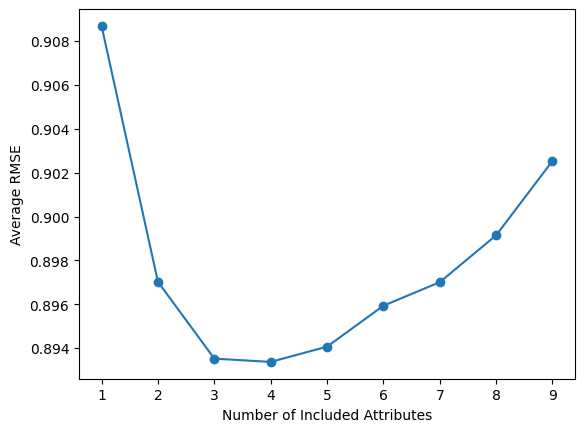

In [45]:
plt.plot(range(1, 10), rmses, "-o")
plt.xlabel("Number of Included Attributes")
plt.ylabel("Average RMSE")
plt.savefig("rmse_tuning.jpg")

In [22]:
# add one attribute at a time, based on average n
remaining_attributes = set(["collection", "budget", "genres", "language", "companies", "countries", "revenue", "overview_cluster", "cast"])
included_attributes = []
ns = [] 

for i in range(9):
    attributes_to_include = set(included_attributes)
    
    min_n = float("inf")
    best_attribute = None
    
    for attribute in remaining_attributes:
        attributes_to_include.add(attribute)
        
        edges = form_edges(attributes_to_include)
        g = nx.Graph(list(edges))
        g.add_nodes_from(nodes)
        
        average_predicted_rmse, average_n = evaluate_model(g, validation_users, verbose=False)
        if average_n < min_n:
            min_n = average_n
            best_attribute = attribute 
        
        attributes_to_include.remove(attribute)
    
    ns.append(min_n)
    included_attributes.append(best_attribute)
    remaining_attributes.remove(best_attribute)

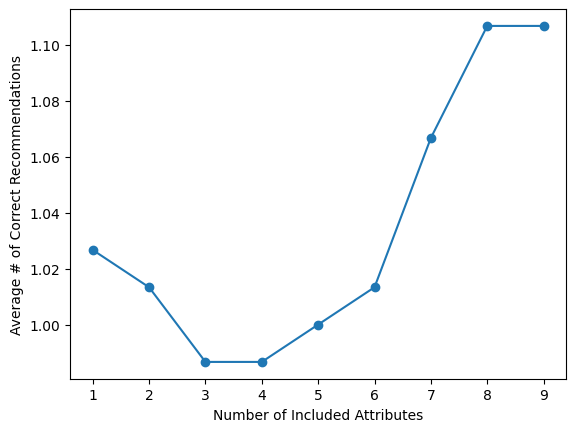

In [44]:
plt.plot(range(1, 10), ns, "-o")
plt.xlabel("Number of Included Attributes")
plt.ylabel("Average # of Correct Recommendations")
plt.savefig("n_tuning.jpg")

In [24]:
included_attributes

['overview_cluster',
 'countries',
 'language',
 'companies',
 'collection',
 'budget',
 'revenue',
 'genres',
 'cast']